# What to do about islands and connectivity

When you create or load a graph, you may have see a warning about islands, like this one for Massachusetts:

In [64]:
from gerrychain import Graph
graph = Graph.from_json("./Block_Groups/BG25.json")

c:\dev\gerrychain\gerrychain\graph\graph.py:216: UserWarning: Found islands (degree-0 nodes). Indices of islands: {2552, 3107}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


This warning is telling you that there are a couple nodes (2552, 3107) that have no neighbors---that is, they are completely disconnected from the rest of the graph. In addition to these nodes without neighbors, we can also have a whole cluster of nodes that is disconnected from the rest of the graph.

These are a problem because we want the districting plans we generate to have contiguous districts, and any district with one of these islands will not be contiguous. In addition, spanning tree-based methods like the ReCom proposal or the `recursive_tree_part` seed-creation method require that the graph be connected---starting with a disconnected graph can lead to mysterious `KeyError`s and infinite loops.

These islands and disconnected components show up when there are actual geographic islands, or (for example) when there is a unit that is connected to the mainland by a bridge but whose official boundary in the shapefile does not touch the mainland's boundary.

This notebook will show you how to diagnose these contiguity problems, and will give you a few different strategies for dealing with islands and disconnected components so that you can get your graph to a workable state for generating ensembles of districting plans.

## Figuring out what is going on

The first step in the process is to figure out what is going on. To see the node IDs of the islands that GerryChain warned us about, we can inspect `graph.islands`:

In [65]:
islands = graph.islands
islands

{2552, 3107}

GerryChain warns you when there are islands, but we'll also want to see if there are whole disconnected components of the graph. We can use the [NetworkX](https://networkx.github.io) function `connected_components` to do this. The `connected_components` function yields the set of node IDs in each connected component of the graph. We'll put these sets into a list, and then print out their lengths to see how bad the contiguity situation is:

In [66]:
from networkx import is_connected, connected_components

In [67]:
components = list(connected_components(graph))

[len(c) for c in components]

[4922, 25, 19, 11, 1, 1]

We have one big component with 4922 nodes. The two components with 1 node are the islands that GerryChain warned us about. Then we also have another few disconnected components with 25, 19, and 11 nodes each.

To fix these problems, we have two options. The first strategy is to just delete these disconnected components, and do our analysis on the big connected component. This might be the right way to go if you are just trying to get started---you can always go back and make a better fix later when you want to make sure your results are sound.

The second strategy is to manually add edges to the graph to connect all of the disconnected components. This is more involved but will give you a much better graph for your analysis.

## Strategy 1: delete the problem components

For the quick and very dirty route, we can just delete all of the nodes in components that are causing us problems:

In [68]:
biggest_component_size = max(len(c) for c in components)
problem_components = [c for c in components if len(c) != biggest_component_size]

In [69]:
for component in problem_components:
    for node in component:
        graph.remove_node(node)

We can verify that our graph is now connected:

In [70]:
is_connected(graph)

True

And now we're ready to run a chain! Let's save the graph in a new `.json` file so that we don't have to do this fix every time we want to run a chain.

In [30]:
graph.to_json("./my_graph_with_islands_deleted.json")

## Strategy 2: connect the components manually

Deleting the problem components will make it easier for your code to run, but we should not use this method when we actually care about the results we are getting. Deleting nodes from the graph also deletes all the people who live in those nodes, which is strictly not OK, morally speaking. For a better, more laborious solution, we will:

- Use QGIS to open the Shapefile that our graph was made from
- Examine the disconnected components in QGIS, and 
- Judiciously add edges to the graph to make it connected.

This requires making some human judgements about which units are "near" to each other, for the purposes of district contiguity. This is an art more than a science, with a lot of questions with no single right answer. For instance, should all of the Hawaiian islands be connected to one another, or connected in a chain from east to west? Should the upper peninsula of Michigan connect to the lower pensinsula only at the Mackinac bridge, or all along the coast?

### Downloading the shapefile

This graph was made from census block groups. We can use [geopandas](https://geopandas.org) to open the zipped Shapefile.

In [115]:
df = geopandas.read_file("zip://BG25.zip")

### Inspecting the disconnected components

The next step in the process is to open the block group Shapefile in QGIS so we can see what's going on. For the purposes of this Jupyter notebook, we'll plot our GeoDataFrame `df`.

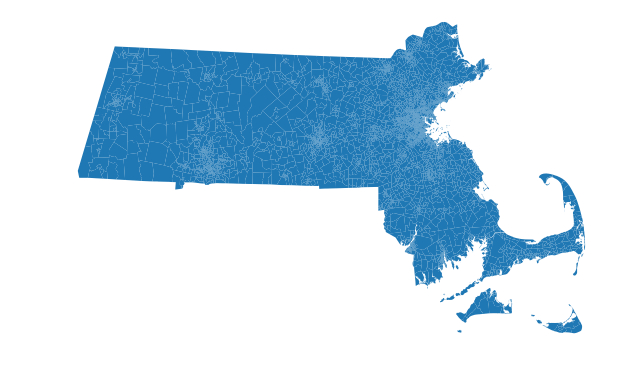

In [125]:
import matplotlib.pyplot as plt

# Change the projection so we can plot it:
df.to_crs({"init": "epsg:26986"}, inplace=True)

df.plot(figsize=(10, 10))
plt.axis('off')
plt.show()

It's not immediately clear from this plot where the disconnected components are. But we can use our adjacency graph to get the GEOIDs of the disconnected nodes, which we can then highlight using QGIS (or geopandas).

Let's load our graph in again and verify that it's not connected.

In [193]:
graph = Graph.from_json("./Block_Groups/BG25.json")

c:\dev\gerrychain\gerrychain\graph\graph.py:216: UserWarning: Found islands (degree-0 nodes). Indices of islands: {2552, 3107}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


In [194]:
assert is_connected(graph) is False

Now we'll collect the GEOIDs of all of the nodes and use them to highlight the block groups that we need to connect.

In [195]:
components = list(connected_components(graph))
[len(c) for c in components]

[4922, 25, 19, 11, 1, 1]

In [196]:
biggest_component_size = max(len(c) for c in components)
problem_components = [c for c in components if len(c) != biggest_component_size]

problem_nodes = [node for component in problem_components for node in component]
problem_geoids = [graph.nodes[node]["GEOID10"] for node in problem_nodes]

In [197]:
is_a_problem = df["GEOID10"].isin(problem_geoids)

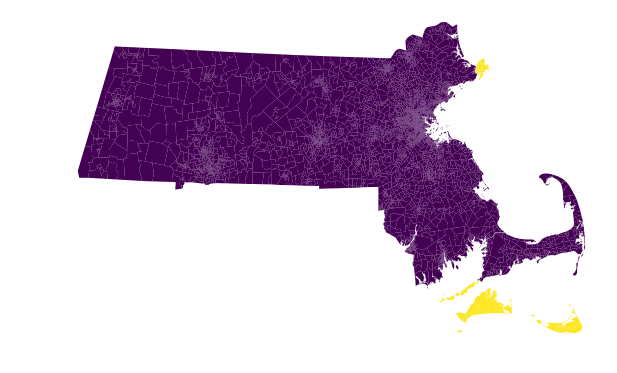

In [225]:
df.plot(column=is_a_problem, figsize=(10, 10))
plt.axis('off')
plt.show()

We can do the same thing in QGIS by using the "Select by Expression" feature with an expression like this:
```
"GEOID10" in (
 '250092215001',
 '250092216001',
 '250092214003',
 '250092213001',
 '250092214002',
 '250092215002', ... 
)
```
where we've copied and pasted the GEOIDs from our `problem_geoids` variable into the `...` part between the parentheses.

Then click "Select features" and you should see these same features highlighted on the map.

### Adding edges to the graph

Now comes the fun part! We want to identify some edges that we can add to make the graph connected. To do this, we want to:

- Zoom into the areas where these disconnected block groups (highlighted in yellow) are close to block groups in the main connected component (in purple)
- Use the "Identify features" tool to inspect the attributes of the yellow and purple block groups that we want to connect
- Copy the `"GEOID10"` attribute values for both of the units we want to connect

Once we have these GEOIDs, we can find the corresponding nodes in the graph and add that edge. For the Massachusetts example, here are two GEOIDs of nodes that I want to connect that I found in QGIS:

In [199]:
purple_geoid = "250010149001"
yellow_geoid = "250072004006"

Next, we find the corresponding node using this GEOID. Let's write a function to do this to save some mental space:

In [200]:
def find_node_by_geoid(geoid, graph=graph):
    for node in graph:
        if graph.nodes[node]["GEOID10"] == geoid:
            return node

In [201]:
purple_node = find_node_by_geoid(purple_geoid)
yellow_node = find_node_by_geoid(yellow_geoid)
purple_node, yellow_node

(955, 2552)

And now we can finally add the edge `(955, 2552)` to connect these nodes:

In [202]:
graph.add_edge(purple_node, yellow_node)

Let's use `connected_components` to see if we've made our graph more connected.

In [203]:
[len(c) for c in connected_components(graph)]

[4923, 25, 19, 11, 1]

Yay! We've connected one of the islands that GerryChain warned us about. Now we'll repeat this process of adding edges until the graph only has one connected component.

Here are all the pairs of GEOIDs that I found that I wanted to connect:

In [217]:
geoids_i_found = [
    ("250072004001", "250072004006"),
    ("250072003001", "250199503071"),
    ("250092218002", "250092219022"),
    ("250259901010", "250251803013")
]

Let's add them:

In [221]:
edges_to_add = [(find_node_by_geoid(u), find_node_by_geoid(v)) for u, v in geoids_i_found]

In [222]:
for u, v in edges_to_add:
    graph.add_edge(u, v)

And let's verify that the graph is connected:

In [223]:
assert len(list(connected_components(graph))) == 1

is_connected(graph)

True

Hooray! 🎉🎉🎉 The graph is connected now! 🎉🎉🎉

Now we can run a proper Markov chain, without deleting any people from the graph.

## Discontiguous plans

In addition to connectivity problems in the actual graph, you may also need to think about discontiguities in districting plans. That is, if we want to use a real-life plan as our initial state in GerryChain, we will want it to be contiguous, so we need to make sure that our graph structure has the right edges in place for that to be true.

The process for fixing discontiguous plans is similar to the above process. The only difference is in how we identify the problematic nodes. GerryChain provides a function `contiguous_components` that takes a Partition and returns the contiguous components of each district. 

Here's how we can find those components, using a random example plan with 2 districts for Massachusetts, just to see what a discontiguous plan looks like:

In [241]:
from gerrychain.constraints.contiguity import contiguous_components, contiguous
from gerrychain import Partition

In [239]:
assignment = {}
for node in graph:
    if float(graph.nodes[node]["INTPTLAT10"]) < 42.356767:
        assignment[node] = 0
    else:
        assignment[node] = 1

discontiguous_plan = Partition(graph, assignment)

In [242]:
contiguous(discontiguous_plan)

False

In [243]:
contiguous_components(discontiguous_plan)

{0: [<Graph [2960 nodes, 7889 edges]>,
  <Graph [1 nodes, 0 edges]>,
  <Graph [1 nodes, 0 edges]>],
 1: [<Graph [2010 nodes, 5422 edges]>, <Graph [7 nodes, 15 edges]>]}

For any district with more than one contiguous component, you'll want to do the exact same process that we did with the overall graph above: add edges until there is only one contiguous component.

If the starting plan is not important to you, then you might want to use a function like `recursive_tree_part` to generate a starting plan from scratch.